In [1]:
import shap
shap.initjs()
import boto3
import numpy as np
import pandas as pd
import xgboost as xgb
import math

/Users/charlesmiller/.local/share/virtualenvs/model-tester-tjbixvgX/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
hyperparams = {'subsample': 0.6, 'num_round': 1000, 'min_child_weight': 10, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 2, 'colsample_bytree': 1}
features = ['min_30_diff', 'bb_category', 'return_vol_5D_diff', 'close_10DMA_diff', 'return_vol_5D', 'price_range_H', 'price_20Ddiff', 'roc_vol5', 'DIplus', 
            'macd_15MA', 'volume_sum15_10DMA_diff', 'roc_vol_15MA_diff', 'range_vol_stddev20D_diff', 'volume_15MA_diff', 'volume_sum15', 'roc_15MA_diff', 'price_10Ddiff', 
            'Low-Close', 'roc_vol', 'SPY_diff_H', 'roc8H', 'DIminus', 'day_of_month', 'ret_vol_stddev20D_diff', 'High-Low', 'PrevClose-L', 'roc8H_15MA_diff', 'High-Close', 
            'cmf_15MA_diff', 'roc5', 'max_30_diff', 'close_20DMA_diff', 'return_vol_10D_diff', 'roc3', 'rsi', 'cmf', 'day_of_week', 'return_vol_8H', 'return_vol_8H_diff', 'SPY_5d_diff', 'H-L', 'bb_spread', 'SPY_20d_diff', 'price_range_8MA_diff']
strategy = "CDBFP_1D"

In [3]:
def configure_dates(data,strategy):
    if strategy in ["CDBFC","CDBFP"]:
        data = data.loc[data['day_of_week'].isin([0,1,2])] 
    elif strategy in ["CDBFC_1D","CDBFP_1D"]:
        data = data.loc[data['day_of_week'].isin([0,1,2,3])]
    return data


data = pd.read_csv(f'/Users/charlesmiller/Documents/model_tester_data/BF/2015-01-01_2024-05-03EXP.csv')
data['dt'] = pd.to_datetime(data['date'])
data['one_max_vol'] = (data['one_max']/data['return_vol_5D']).round(3)
data['three_max_vol'] = (data['three_max']/data['return_vol_5D']).round(3)
data['one_min_vol'] = (data['one_min']/data['return_vol_5D']).round(3)
data['three_min_vol'] = (data['three_min']/data['return_vol_5D']).round(3)    
# data['one_max_vol30'] = (data['one_max']/data['return_vol_30D']).round(3)
# data['three_max_vol30'] = (data['three_max']/data['return_vol_30D']).round(3)
# data['one_min_vol30'] = (data['one_min']/data['return_vol_30D']).round(3)
# data['three_min_vol30'] = (data['three_min']/data['return_vol_30D']).round(3)    
# data['cd_vol'] = (data['close_diff']/data['return_vol_10D']).round(3)
# data['cd_vol3'] = (data['close_diff3']/data['return_vol_10D']).round(3)
# data['cd_vol30'] = (data['close_diff']/data['return_vol_30D']).round(3)
data['cd_vol'] = (data['price_change_D']/data['return_vol_5D']).round(3)
data['cd_vol3'] = (data['price_3Ddiff']/data['return_vol_5D']).round(3)
# data['cd_vol330'] = (data['close_diff3']/data['return_vol_30D']).round(3)
data = data.loc[data['symbol'].isin(["QQQ","SPY","IWM"])]
data = configure_dates(data,strategy)
data.replace([np.inf, -np.inf], 0, inplace=True)

In [4]:
train_value = math.floor(len(data)*0.8)
dataset = data.iloc[:train_value]
validation_dataset = data.iloc[train_value:]

target_label = 'one_min_vol'
target_value = dataset[target_label].quantile(0.6).round(3)

dataset.loc[:, 'label'] = (dataset[target_label] < target_value).astype(int)
validation_dataset.loc[:, 'label'] = (validation_dataset[target_label] < target_value).astype(int)

# dataset = dataset.round(3)
# validation_dataset = validation_dataset.round(3)

X = dataset[features].astype(float)
y = dataset['label']

X_validate = validation_dataset[features].astype(float)
y_validate = validation_dataset['label']


xgb_model = xgb.XGBClassifier(subsample=hyperparams['subsample'],num_round=hyperparams['num_round'],min_child_weight=hyperparams['min_child_weight'],max_depth=hyperparams['max_depth'],learning_rate=hyperparams['learning_rate'],gamma=hyperparams['gamma'],colsample_bytree=hyperparams['colsample_bytree'],verbosity=0,objective='binary:logistic',random_state=42)
xgb_model.fit(X, y,
       eval_set=[(X, y),
                 (X_validate, y_validate)
                ]
      )
# print(y.value_counts())
# predictions = xgb_model.predict(X_validate)
# probabilities = xgb_model.predict_proba(X_validate)



[0]	validation_0-logloss:0.65745	validation_1-logloss:0.66626
[1]	validation_0-logloss:0.64404	validation_1-logloss:0.66587
[2]	validation_0-logloss:0.63235	validation_1-logloss:0.66515
[3]	validation_0-logloss:0.62035	validation_1-logloss:0.66432
[4]	validation_0-logloss:0.60859	validation_1-logloss:0.66554
[5]	validation_0-logloss:0.59823	validation_1-logloss:0.66653
[6]	validation_0-logloss:0.58922	validation_1-logloss:0.66511
[7]	validation_0-logloss:0.58091	validation_1-logloss:0.66541
[8]	validation_0-logloss:0.57050	validation_1-logloss:0.66542
[9]	validation_0-logloss:0.56179	validation_1-logloss:0.66469
[10]	validation_0-logloss:0.55606	validation_1-logloss:0.66518
[11]	validation_0-logloss:0.54866	validation_1-logloss:0.66711
[12]	validation_0-logloss:0.54147	validation_1-logloss:0.66791
[13]	validation_0-logloss:0.53508	validation_1-logloss:0.66734
[14]	validation_0-logloss:0.52989	validation_1-logloss:0.66778
[15]	validation_0-logloss:0.52485	validation_1-logloss:0.66794
[1

/var/folders/tq/_9q_lv1s2bndbr3tzzn08x4r0000gn/T/ipykernel_66949/3078706216.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.loc[:, 'label'] = (dataset[target_label] < target_value).astype(int)
/var/folders/tq/_9q_lv1s2bndbr3tzzn08x4r0000gn/T/ipykernel_66949/3078706216.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_dataset.loc[:, 'label'] = (validation_dataset[target_label] < target_value).astype(int)


[20]	validation_0-logloss:0.49965	validation_1-logloss:0.67056
[21]	validation_0-logloss:0.49506	validation_1-logloss:0.67206
[22]	validation_0-logloss:0.49082	validation_1-logloss:0.67213
[23]	validation_0-logloss:0.48750	validation_1-logloss:0.67302
[24]	validation_0-logloss:0.48512	validation_1-logloss:0.67256
[25]	validation_0-logloss:0.47901	validation_1-logloss:0.67403
[26]	validation_0-logloss:0.47509	validation_1-logloss:0.67409
[27]	validation_0-logloss:0.47051	validation_1-logloss:0.67547
[28]	validation_0-logloss:0.46552	validation_1-logloss:0.67693
[29]	validation_0-logloss:0.46182	validation_1-logloss:0.67710
[30]	validation_0-logloss:0.45961	validation_1-logloss:0.67782
[31]	validation_0-logloss:0.45733	validation_1-logloss:0.67969
[32]	validation_0-logloss:0.45277	validation_1-logloss:0.68025
[33]	validation_0-logloss:0.44748	validation_1-logloss:0.68204
[34]	validation_0-logloss:0.44671	validation_1-logloss:0.68221
[35]	validation_0-logloss:0.44481	validation_1-logloss:

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, num_round=1000, ...)

In [5]:
shap_ex = shap.TreeExplainer(xgb_model)
vals = shap_ex(X_validate)
shap_df = pd.DataFrame(vals.values, columns=X_validate.columns)

In [6]:
print(shap_df)

      min_30_diff  bb_category  return_vol_5D_diff  close_10DMA_diff  \
0       -0.067145    -0.000319           -0.010249          0.159739   
1       -0.097923    -0.000370            0.053485          0.164591   
2       -0.136367    -0.000489            0.041078          0.168404   
3       -0.033575    -0.000387           -0.041871          0.166880   
4       -0.095846    -0.000370           -0.012039          0.090690   
...           ...          ...                 ...               ...   
6738    -0.109891    -0.001704            0.069375          0.045872   
6739    -0.030160    -0.001611            0.039525          0.016647   
6740     0.049955    -0.001704            0.077162          0.017998   
6741    -0.100382    -0.001704            0.093968         -0.004476   
6742    -0.005798    -0.001611            0.025792          0.045369   

      return_vol_5D  price_range_H  price_20Ddiff  roc_vol5    DIplus  \
0         -0.582489       0.073235       0.023754  0.020630  0

In [7]:
print(pd.concat([shap_df.sum(axis='columns')
.rename('pred') + vals.base_values,
pd.Series(y_validate, name='true')], axis='columns')
.assign(prob=lambda adf: (np.exp(adf.pred) / 
(1 + np.exp(adf.pred)))))

            pred  true      prob
0       2.363087   NaN  0.913969
1       1.567015   NaN  0.827358
2       1.380714   NaN  0.799106
3       1.836132   NaN  0.862491
4       1.032934   NaN  0.737484
...          ...   ...       ...
422881       NaN   1.0       NaN
422882       NaN   1.0       NaN
422913       NaN   1.0       NaN
422914       NaN   1.0       NaN
422915       NaN   1.0       NaN

[13486 rows x 3 columns]


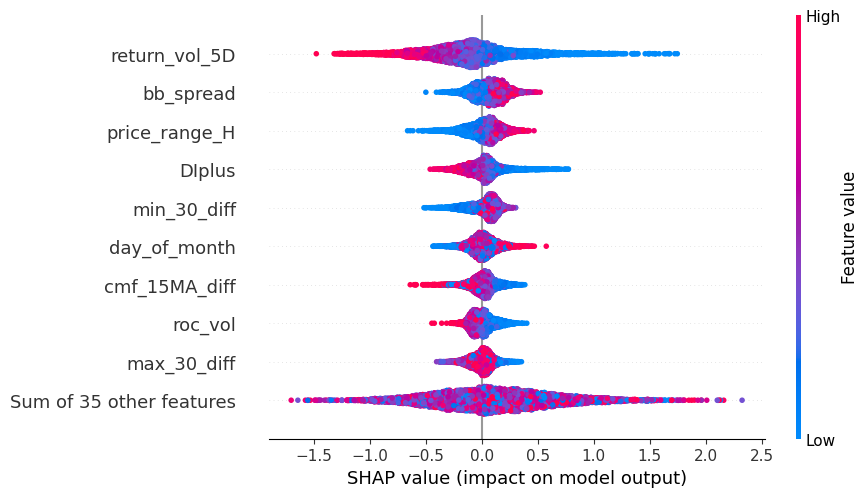

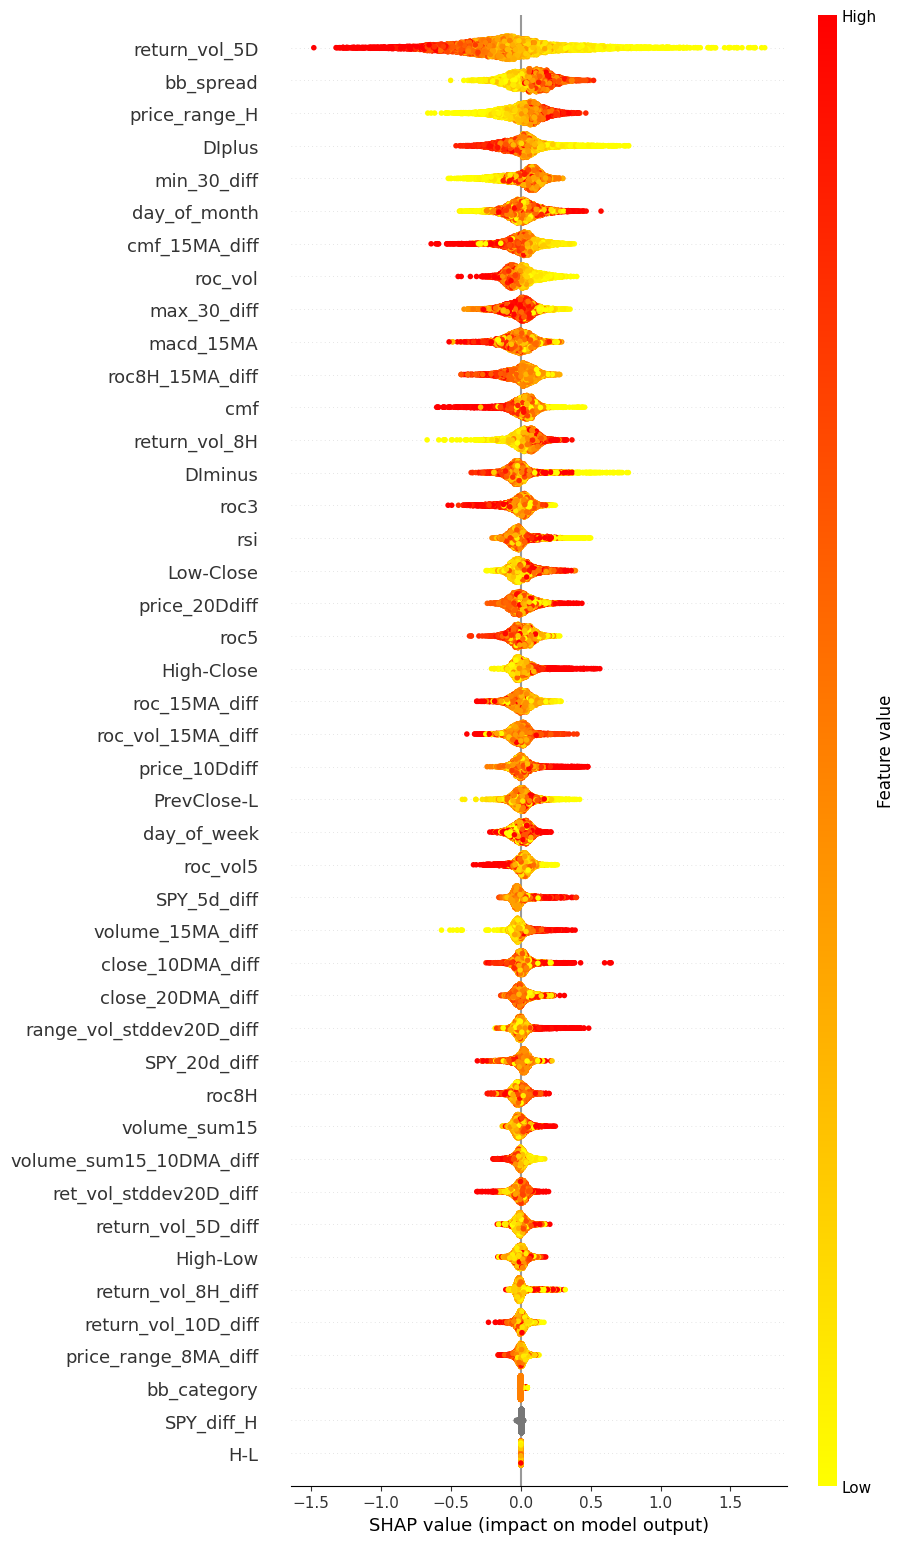

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 4))
shap.plots.beeswarm(vals)

from matplotlib import cm
fig = plt.figure(figsize=(8, 4))
shap.plots.beeswarm(vals, max_display=len(X_validate.columns), color=cm.autumn_r)